# 1

## a)

In [13]:
import pandas as pd
import numpy as np
url = 'http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/prostate.data'
df = pd.read_csv(url, sep='\t', header=0)
df = df.drop('Unnamed: 0', axis=1)
istrain_str = df['train']
istrain = np.asarray([True if s == 'T' else False for s in istrain_str])
istest = np.logical_not(istrain)
df = df.drop('train', axis=1)

#print df

## b)

In [14]:
#df.shape
#df.info()
#df.describe()

## c)

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled['lpsa'] = df['lpsa']

# print df_scaled

## d)

In [55]:
import sklearn.linear_model as lm
X = df_scaled.ix[:,:-1]
N = X.shape[0]
X.insert(X.shape[1], 'intercept', np.ones(N))
y = df_scaled['lpsa']
Xtrain = X[istrain]
ytrain = y[istrain]
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]
linreg = lm.LinearRegression(fit_intercept = False)
linreg.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

## e)

In [17]:
#print linreg.coef_

cols = list(Xtrain.columns)
cols.remove("intercept")

Xtrain_zscores = pd.DataFrame()

for col in cols:
    col_zscore = col + '_zscore'
    Xtrain_zscores[col_zscore] = (Xtrain[col] - Xtrain[col].mean())/Xtrain[col].std(ddof=0)
    
    
#zscore_matrix = Xtrain_zscores.as_matrix().transpose().tolist()

## f)

In [18]:
yhat_test = linreg.predict(Xtest)
mse_test = np.mean(np.power(yhat_test - ytest, 2))
mse_test_p = np.mean(np.absolute((yhat_test - ytest)*(100/ytest)))
from sklearn import cross_validation
Xm = Xtrain.as_matrix()
ym = ytrain.as_matrix()

#print mse_test
#print mse_test_p
#print

K=5
k_fold = cross_validation.KFold(len(Xm),K)
mse_cv = 0
mse_cv_p = 0
for k, (train, val) in enumerate(k_fold):
    linreg = lm.LinearRegression(fit_intercept = False)
    linreg.fit(Xm[train], ym[train])
    yhat_val = linreg.predict(Xm[val])
    mse_fold = np.mean(np.power(yhat_val - ym[val], 2))
    mse_fold_p = np.mean(np.absolute((yhat_val - ym[val])*(100/ym[val])))
    mse_cv += mse_fold
    mse_cv_p += mse_fold_p
mse_cv = mse_cv / K
mse_cv_p = mse_cv_p / K

#print mse_cv
#print mse_cv_p
#print

K=10
k_fold = cross_validation.KFold(len(Xm),K)
mse_cv = 0
mse_cv_p = 0
for k, (train, val) in enumerate(k_fold):
    linreg = lm.LinearRegression(fit_intercept = False)
    linreg.fit(Xm[train], ym[train])
    yhat_val = linreg.predict(Xm[val])
    mse_fold = np.mean(np.power(yhat_val - ym[val], 2))
    mse_fold_p = np.mean(np.absolute((yhat_val - ym[val])*(100/ym[val])))
    mse_cv += mse_fold
    mse_cv_p += mse_fold_p
mse_cv = mse_cv / K
mse_cv_p = mse_cv_p / K

#print mse_cv
#print mse_cv_p

## g)

In [19]:
%matplotlib inline

import statsmodels.api as sm
import pylab

yhat_train = linreg.predict(Xtrain)
mse_train = np.power(yhat_train - ytrain, 2)

#sm.qqplot(mse_train, line='r')

pylab.show()

#asimetrica a la izquierda

# 2 

## a) NO COPIAR

In [20]:
def fss(x, y, names_x, k = 10000):
    p = x.shape[1]-1
    k = min(p, k)
    names_x = np.array(names_x)
    remaining = range(0, p)
    selected = [p]
    current_score = 0.0
    best_new_score = 0.0
    while remaining and len(selected)<=k :
        score_candidates = []
        for candidate in remaining:
            model = lm.LinearRegression(fit_intercept=False)
            indexes = selected + [candidate]
            x_train = x[:,indexes]
            predictions_train = model.fit(x_train, y).predict(x_train)
            residuals_train = predictions_train - y
            mse_candidate = np.mean(np.power(residuals_train, 2))
            score_candidates.append((mse_candidate, candidate))
        score_candidates.sort()
        score_candidates[:] = score_candidates[::-1]
        best_new_score, best_candidate = score_candidates.pop()
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        print "selected = %s ..."%names_x[best_candidate]
        print "totalvars = %d, mse = %f"%(len(indexes)-1,best_new_score)
    return selected

names_regressors = ["Lcavol", "Lweight", "Age", "Lbph", "Svi", "Lcp", "Gleason", "Pgg45"]
fss(Xm,ym,names_regressors)

selected = Lcavol ...
totalvars = 1, mse = 0.664606
selected = Lweight ...
totalvars = 2, mse = 0.553610
selected = Svi ...
totalvars = 3, mse = 0.521011
selected = Lbph ...
totalvars = 4, mse = 0.489776
selected = Pgg45 ...
totalvars = 5, mse = 0.478648
selected = Lcp ...
totalvars = 6, mse = 0.455818
selected = Age ...
totalvars = 7, mse = 0.439363
selected = Gleason ...
totalvars = 8, mse = 0.439200


[8L, 0, 1, 4, 3, 7, 5, 2, 6]

## b)

In [77]:
def fss(x, y, names_x, k = 10000):
    p = x.shape[1]
    k = min(p, k)
    names_x = np.array(names_x)
    remaining = range(0, p)
    selected = []
    current_score = 0.0
    best_new_score = 0.0
    while len(remaining)>2 :
        score_candidates = []
        for candidate in remaining:
            model = lm.LinearRegression(fit_intercept=False)
            indexes = remaining[:]
            indexes.remove(candidate)
            x_train = x[:,indexes]
            predictions_train = model.fit(x_train, y).predict(x_train)
            residuals_train = predictions_train - y
            mse_candidate = np.mean(np.power(residuals_train, 2))
            score_candidates.append((mse_candidate, candidate))
        score_candidates.sort()
        score_candidates[:] = score_candidates[::-1]
        best_new_score, best_candidate = score_candidates.pop()
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        print "removed = %s ..."%names_x[best_candidate]
        print "totalvars = %d, mse = %f"%(len(indexes)-1,best_new_score)
    
    return selected

names_regressors = ["Lcavol", "Lweight", "Age", "Lbph", "Svi", "Lcp", "Gleason", "Pgg45"]
fss(Xm,ym,names_regressors)

removed = Gleason ...
totalvars = 7, mse = 0.439363
removed = Age ...
totalvars = 6, mse = 0.455818
removed = Lcp ...
totalvars = 5, mse = 0.478648
removed = Pgg45 ...
totalvars = 4, mse = 0.489776
removed = Lbph ...
totalvars = 3, mse = 0.521011
removed = Svi ...
totalvars = 2, mse = 0.553610
removed = Lweight ...
totalvars = 1, mse = 0.664606


[6, 2, 5, 7, 3, 4, 1]

# 3

## a)

(50L,)
(50L,)
(50L,)
(50L,)
(50L,)
(50L,)
(50L,)
(50L,)
(50L,)
(50L,)
(50L,)
(50L,)
(50L,)
(50L,)
(50L,)
(50L,)


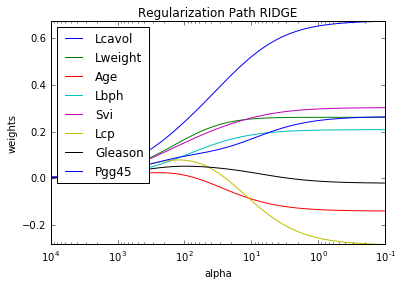

In [22]:
from sklearn.linear_model import Ridge
import matplotlib.pylab as plt
X = X.drop('intercept', axis=1)
Xtrain = X[istrain]
ytrain = y[istrain]
names_regressors = ["Lcavol", "Lweight", "Age", "Lbph", "Svi", "Lcp", "Gleason", "Pgg45"]
alphas_ = np.logspace(4,-1,base=10)
coefs = []
model = Ridge(fit_intercept=True,solver='svd')

for a in alphas_:
    model.set_params(alpha=a)
    model.fit(Xtrain, ytrain)
    coefs.append(model.coef_)
    
ax = plt.gca()

for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    print alphas_.shape
    print y_arr.shape
    plt.plot(alphas_, y_arr, label=label)
    
plt.legend()
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1]) # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Regularization Path RIDGE')
plt.axis('tight')
plt.legend(loc=2)
plt.show()